# QUANTUM APPROXIMATE OPTIMIZATION ALGORITHM (QAOA)

In this tutorial we show how to (approximately) solve binary combinatorial optimization problems, using the __Quantum Approximate Optimization Algorithm (QAOA)__, as introduced [here](https://arxiv.org/abs/1411.4028). 
The QAOA algorithm belongs to the class of __hybrid quantum algorithms__ (leveraging both classical as well as quantum compute), that are widely believed to be the working horse for the current __NISQ (noisy intermediate-scale quantum) era__.
To validate our approach we benchmark our results with exact results as obtained from classical QUBO solvers. 

We provide a step-by-step walkthrough explaining the QAOA quantum algorithm and show how to build the corresponding parametrized quantum circuit ansatz using the ```Braket``` SDK, with simple modular building blocks (that can be re-used for other purposes). 
We use open-source off-the-shelf ```scipy``` optimizers for classical numerical optimization. 
While we demonstrate our proof-of-concept approach using classical simulators for circuit execution, our code could in principle be run on actual quantum hardware by simply changing the definition of the ```device``` object (provided that the gate set used in the ansatz is supported by the backend, as is the case here for IonQ; for Rigetti we need to apply one more extra trick as shown below).   

## BACKGROUND: QUADRATIC BINARY OPTIMIZATION PROBLEMS

__Combinatorial optimization__: Problems involving a large number of yes/no decisions and each set of decisions yields a corresponding objective function value–like a cost or profit value. 
Finding good solutions is extremely difficult. 
Applications found in: Logistics, Scheduling, Planning, Portfolio optimization, Graph coloring. 

__QUBO__: The QUBO model unifies a rich variety of NP-hard combinatorial optimization problems:
Quadratic Assignment Problems 
Capital Budgeting Problems 
Task Allocation Problems
Maximum-Cut Problems
There is a 1:1 correspondence between QUBO problems and Ising problems in physics. 

__Max-Cut__ is paradigm combinatorial optimization problem. 
Given a graph with vertex set $V$ and edge set $E$, we seek partition of $V$ into two subsets with maximum cut. 
In short, you score a point whenever an edge connects two nodes with different colors. 
Problem: Graph coloring problem with $2^𝑁$ possible solutions (exponential explosion). 
Applications: Portfolio optimization (buy/sell asset). Clustering (customer in cluster A or B). 

__Graph coloring problem__: Given a graph of nodes and edges, goal is to color each node red or blue, then score a point for each node that is next to a node of different color. Find a coloring that scores the most points. 

__Applications__ can be found in: 
- Clustering for marketing purposes (segment your customer base into different clusters for targeted marketing). 
- Portfolio optimization in finance (vertex corresponds to asset, color refers to sell or buy).
- Resource allocation: distribute airplanes over terminals avoiding obverlap conflicts.

We encode the problem as a __minimization problem__ of an __Ising Hamiltonian__, where the cost function reads $$H_{C}=\sum_{i>j} J_{i,j} \sigma_{i}^{z} \sigma_{j}^{z}.$$

<span style="color:red">__TODO__:</span> Flesh out QUBO description.

## BACKGROUND: THE QUANTUM APPROXIMATE OPTIMIZATION ALGORITHM

__QAOA__ designed for QUBO (quadratic unconstrained binary optimization) problems, specifically graph coloring problems (that are generically NP-hard, with exponentialliy increasing solution space). 

We encode the problem as a __minimization problem__ of an __Ising Hamiltonian__, where the cost function reads $$H_{C}=\sum_{i>j} J_{i,j} \sigma_{i}^{z} \sigma_{j}^{z}.$$

<span style="color:red">__TODO__:</span> Flesh out QAOA description. Add general hybrid intro (as done in VQE TIM). 

## IMPORTS and SETUP

For classical benchmarking we will be using the python library ```pyqubo```, as used in our helper script ```utils_classical```. If not already present in your virtual environment, you can install this library simply with ```pip install pyqubo```. 

In [1]:
# general imports
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import time
from datetime import datetime
import pickle

# magic line for producing visualizations in notebook
%matplotlib inline

In [2]:
# fix random seed for reproducibility
np.random.seed(0)

In [3]:
# AWS imports: Import Braket SDK modules
import boto3
from braket.circuits import Circuit, Observable
from braket.aws import AwsQuantumSimulator, AwsSession
from braket.devices import LocalSimulator

In [4]:
from utils_classical import plot_colored_graph, plot_colored_graph_simple, solve_classical_ising
# auto reload external files, so that we can edit the external .py file and immediately see the changes here
%load_ext autoreload
%autoreload 2

__NOTE__: Please enter your desired backend device and S3 location (bucket and key) below. If you are working with the local simulator ```LocalSimulator()``` you do not need to specify any S3 location. However, if you are using a different cloud-based backend you need to specify a S3 location where your results will be stored. In this case you need to replace the API call ```device.run(circuit, shots=SHOTS).result()``` below with ```device.run(circuit, s3_folder, shots=SHOTS).result()```. 

In [5]:
# set up backend: Local Schroedinger Simulator
device = LocalSimulator()

# setup s3 folder (not needed for the LocalSimulator backend, but required for all other backends)
my_bucket = "braket-bravehearts"
my_prefix = "simulation-output"
s3_folder = (my_bucket, my_prefix)

## PROBLEM SETUP

We consider a graph coloring problem.
Given a graph $G=(V,E)$, made of a set vertices (also called nodes) $V$ and edges $E$, our goal is to color each node red or blue, then score a point for each node that is next to a node of different color. 
We strive to find the optimal coloring that scores the largest number of points.
To this end, we will address the dual problem of finding the minimum energy of the corresponding Ising Hamiltonian. 
To get started, we first use the open-source ```networkx``` library to visualize the problem graph. 
We feel to play with the parameters $n$ and $m$ to consider other graphs of your choice. 

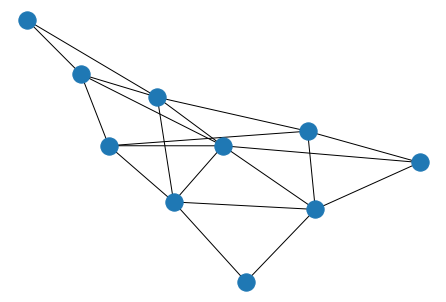

In [6]:
# setup Erdos Renyi graph
n = 10  # 10 nodes
m = 20  # 20 edges

# define graph object
G = nx.gnm_random_graph(n, m, seed=42)
# positions for all nodes
pos = nx.spring_layout(G)

# draw graph
nx.draw(G, pos)
plt.show()

In [7]:
# set Ising matrix 
Jfull = nx.adjacency_matrix(G).todense()
Jfull = np.array(Jfull)

# get off-diagonal upper triangular matrix
J = np.triu(Jfull, k=1)

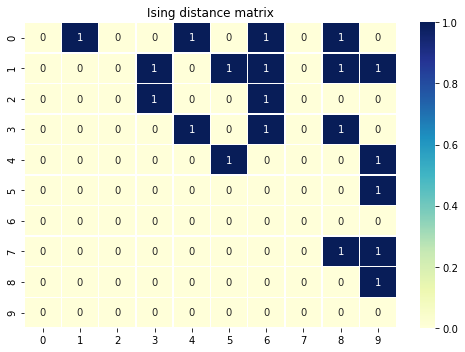

In [8]:
# plot Ising matrix
plt.figure(figsize=[7, 5])
sns.heatmap(J, annot=True,  linewidths=.5, cmap="YlGnBu", annot_kws = {'alpha': 1})
plt.title('Ising distance matrix');
plt.tight_layout();

## IMPLEMENTATION OF QAOA WITH BRAKET 

In this section we develop a set of useful helper functions that we will explain in detail below. 
Specifically we provide simple building blocks for the core modules of our QAOA algorithm, that is (i) a function called ```circuit``` that defines the parametrized ansatz, (ii) a function called ```objective_function``` that takes a list of variational parameters as input, and returns the cost associated with those parameters and finally (iii) a function ```train``` to run the entire QAOA algorithm for given ansatz. 
This way we can solve the problem in a clean and modular approach.

<span style="color:red">__TODO__:</span> 
* Load these functions from helper ```utils.py``` once polished. 
* Check Rigetti backend for implementation of ZZ gate. 

In [9]:
def ZZgate(q1, q2, gamma):
    """
    function that returns a circuit implementing exp(-i \gamma Z_i Z_j) using CNOT gates if ZZ not supported
    """
    
    # get a circuit
    circ_zz = Circuit()
    
    # construct decomposition of ZZ
    circ_zz.cnot(q1, q2).rz(q2, gamma).cnot(q1, q2)
    
    return circ_zz


# function to implement evolution with driver Hamiltonian
def driver(beta, n_qubits):
    """
    Returns circuit for driver Hamiltonian U(Hb, beta)
    """
    # instantiate circuit object
    circ = Circuit()

    for qubit in range(n_qubits):
        gate = Circuit().rx(qubit, 2*beta)
        circ.add(gate)
    
    return circ


# helper function for evolution with cost Hamiltonian
def cost_circuit(gamma, n_qubits, ising):
    """
    returns circuit for evolution with cost Hamiltonian
    """
    # instantiate circuit object
    circ = Circuit()

    # Ising matrix defines relevant entries, so use indices of those entries
    idx = ising.nonzero()
    result_qubits = list(zip(idx[0], idx[1]))
    
    for qubit_pair in result_qubits:
        if device.name == 'Rigetti':
            gate = ZZgate(qubit_pair[0], qubit_pair[1], gamma)
        else:
            gate = Circuit().zz(qubit_pair[0], qubit_pair[1], angle=2*gamma)
            circ.add(gate)

    return circ


# function to build the QAOA circuit with depth p
def circuit(params, n_qubits, ising):
    """
    function to return full QAOA circuit
    """

    # initialize qaoa circuit with first Hadamard layer: for minimization start in |->
    circ = Circuit()
    X_on_all = Circuit().x(range(0, n_qubits))
    circ.add(X_on_all)
    H_on_all = Circuit().h(range(0, n_qubits))
    circ.add(H_on_all)

    # setup two parameter families
    circuit_length = int(len(params) / 2)
    gammas = params[:circuit_length]
    betas = params[circuit_length:]

    # add circuit layers
    for mm in range(circuit_length):
        circ.add(cost_circuit(gammas[mm], n_qubits, ising))
        circ.add(driver(betas[mm], n_qubits))

    return circ

In [10]:
# function that computes cost function for given params
def objective_function(params, ising, n_qubits, n_shots, tracker):
    """
    objective function takes a list of variational parameters as input,
    and returns the cost associated with those parameters
    """

    print('==================================' * 2)
    print('Calling the quantum circuit. Cycle:', tracker['count'])

    # obtain a quantum circuit instance from the parameters
    qaoa_circuit = circuit(params, n_qubits, ising)

    # Establish observable PauliZ on two qubits (to be defined, as "target" qubits)
    obs = Observable.Z() @ Observable.Z()
    # Ising matrix defines relevant entries (connected qubits), so use indices of those entries
    idx = ising.nonzero()
    result_qubits = list(zip(idx[0], idx[1]))

    for qubit_pair in result_qubits:
        qaoa_circuit.expectation(obs, target=qubit_pair)

    # classically simulate the circuit
    # execute the correct device.run call depending on whether the backend is local or cloud based
    if device.name == 'DefaultSimulator':
        task = device.run(qaoa_circuit, shots=n_shots)
    else:
        task = device.run(qaoa_circuit, s3_folder, 
                          shots=n_shots, poll_timeout_seconds=3*24*60*60)

    # get result for this task
    result = task.result()

    # get metadata
    metadata = result.task_metadata

    # convert results (0 and 1) to ising (-1 and 1)
    meas_ising = result.measurements
    meas_ising[meas_ising == 0] = -1

    # get all energies (for every shot): (n_shots, 1) vector
    all_energies = np.diag(np.dot(meas_ising, np.dot(ising, np.transpose(meas_ising))))

    # find minimum and corresponding classical string
    energy_min = np.min(all_energies)
    print('Minimal energy:', energy_min)
    optimal_string = meas_ising[np.argmin(all_energies)]
    print('Optimal classical string:', optimal_string)

    # store optimal (classical) result/bitstring
    if energy_min < tracker['optimal_energy']:
        tracker.update({'optimal_energy': energy_min})
        tracker.update({'optimal_bitstring': optimal_string})

    # get expectations for observables (across all shots)
    energies = np.array(result.values)

    # energy expectation value
    # energy_expect = np.sum(all_energies) / n_shots
    energy_expect = np.sum(energies)
    print('Approx energy expectation value (cost):', energy_expect)
    # send metrics to CloudWatch
    print(f'cost_avg={energy_expect};')

    # NOTE: could consider other definitions of cost function
    cost = energy_expect
    tracker.update({'count': tracker['count']+1})
    tracker.update({'res': result})

    return cost

In [11]:
# The function to execute the training: run classical minimization.
def train(options, p, ising, n_qubits, n_shots, tracker):
    """
    function to run QAOA algorithm for given, fixed circuit depth p
    """
    print('Starting the training.')

    print('==================================' * 3)
    print('OPTIMIZATION for circuit depth p={depth}'.format(depth=p))

    # initialize
    cost_energy = []
    angles = []

    # randomly initialize variational parameters within appropriate bounds
    gamma_initial = np.random.uniform(0, 2 * np.pi, p).tolist()
    beta_initial = np.random.uniform(0, np.pi, p).tolist()
    params0 = np.array(gamma_initial + beta_initial)
    params0[0] = 0.01
    params0[p] = 0.4
    # set bounds for search space
    bnds_gamma = [(0, 2 * np.pi) for _ in range(int(len(params0) / 2))]
    bnds_beta = [(0, np.pi) for _ in range(int(len(params0) / 2))]
    bnds = bnds_gamma + bnds_beta

    # run classical optimization (example: method='Nelder-Mead')
    result = minimize(objective_function, params0, args=(ising, n_qubits, n_shots, tracker), 
                      options=options, method='SLSQP', bounds=bnds)

    # store result of classical optimization
    result_energy = result.fun
    cost_energy.append(result_energy)
    print('Optimal avg energy:', result_energy)
    result_angle = result.x
    angles.append(result_angle)
    print('Optimal angles:', result_angle)
    print('Training complete.')

    return result_energy, result_angle, tracker

## VISUALIZATION OF THE QAOA ANSATZ

Let us first visualize our parametrized QAOA ansatz for a small number of qubits and fixed (i.e., not optimized) parameters. 
For convenience, the parameters are dispalyed in the circuit (up to a factor of $2$ we have added in our ansatz definition). 
First we prepare the state $|0,0,\dots\rangle \rightarrow |-,-,\dots\rangle$, with $|-\rangle = (|0\rangle -|1\rangle  )/\sqrt{2}$. 
Following the discussion above, we choose to start out with this state as it is the minimal energy state of the simple driver Hamiltonian $H_{B}$. 
This state preparation is followed by one layer of the QAOA ansatz, consisting of evolution with the cost Hamiltonian by $\exp(-i\gamma H_{C})= \prod_{j,l}\exp(-i\gamma J_{j,l}\sigma_{j}^{z}\sigma_{l}^{z}) = \prod_{j,l} ZZ_{j,l}(2\gamma J_{j,l})$, followed by the single-qubit driving term, $\exp(-i\beta H_{B})= \prod_{j} \exp(-i\beta \sigma_{j}^{x})= \prod_{j} R_{j}^{(x)}(2\beta)$.

In [12]:
# set number of qubits and fix parameters
N = 2
gammas = [0.1]
betas = [0.3]
params = gammas + betas

# get circuit ansatz
J_sub = J[:N, :N]  # for demonstration purposes, use small slice of full Ising matrix
my_simple_circuit = circuit(params, N, J_sub)

# print test ansatz circuit
print('Printing test circuit:')
print(my_simple_circuit)

Printing test circuit:
T  : |0|1|   2   |   3   |
                          
q0 : -X-H-ZZ(0.2)-Rx(0.6)-
          |               
q1 : -X-H-ZZ(0.2)-Rx(0.6)-

T  : |0|1|   2   |   3   |


We see that our ansatz produces the expected result for shallow QAOA with $p=1$. 
We run one more sanity check for $p=2$ below. 

In [13]:
# set number of qubits and fix parameters
N = 2
gammas = [0.1, 0.2]
betas = [0.3, 0.4]
params = gammas + betas

# get circuit ansatz
J_sub = J[:N, :N]
my_simple_circuit = circuit(params, N, J_sub)

# print test ansatz circuit
print('Printing test circuit:')
print(my_simple_circuit)

Printing test circuit:
T  : |0|1|   2   |   3   |   4   |   5   |
                                          
q0 : -X-H-ZZ(0.2)-Rx(0.6)-ZZ(0.4)-Rx(0.8)-
          |               |               
q1 : -X-H-ZZ(0.2)-Rx(0.6)-ZZ(0.4)-Rx(0.8)-

T  : |0|1|   2   |   3   |   4   |   5   |


## QAOA SIMULATION ON LOCAL SCHROEDINGER SIMULATOR

We are now all set to run some QAOA simulation experiments. 
First of all, you can play and experiment yourself with the number of qubits $N$. 
Secondly, you may also experiment with the classical optimizer. 
Since we are using an off-the-shelf ```scipy``` minimizer (as described in more detail [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)), you can simply swap between different optimizers by setting the ```method``` parameter accordingly, as done above in the line ```result = minimize(..., method='SLSQP')```. 
Some popular options readily availbale within this library include *Nelder-Mead*, *BFGS* and *COBYLA*. 
As a precautionary warning, note that the classical optimization step may get stuck in a local optimum, rather than finding the global minimum for our parametrized QAOA ansatz wavefunction. 
To address this issue, we may run several optimization loops, starting from different random parameter seeds. 
While this brute-force approach does not provide any guarantee to find the glocal optimum, from a pragmatic point of view at least it does increase the odds of finding an acceptable solution, at the expense of potentially having to run many more circuits on the QPU.

In [14]:
##################################################################################
# set up hyperparameters
##################################################################################

p = 2  # circuit depth for QAOA
print('Circuit depth hyperparameter:', p)
SHOTS = 1000

# set up the problem
n_qubits = J.shape[0]
print('Problem size:', n_qubits)

# initialize reference solution (simple guess)
bitstring_init = -1 * np.ones([n_qubits])
energy_init = np.dot(bitstring_init, np.dot(J, bitstring_init))

# NOTE: scipy.optimize.minimize() does not provide straightforward mechanism to update inputs,
#       so leverage mutability of dict object
tracker = {'count': 1, 'optimal_energy': energy_init, 'optimal_bitstring': bitstring_init, 'res': None}

# set options for classical optimization
options = {'disp': True}
# options = {'disp': True, 'ftol': 1e-08, 'maxiter': 100}

Circuit depth hyperparameter: 2
Problem size: 10


In [15]:
##################################################################################
# run QAOA optimization on graph 
##################################################################################

# kick off training
start = time.time()
result_energy, result_angle, tracker = train(options=options, p=p, ising=J, n_qubits=n_qubits, n_shots=SHOTS, tracker=tracker)
end = time.time()

# print execution time
print('Code execution time [sec]:', end - start)

# print optimized results
print('Optimal energy:', tracker['optimal_energy'])
print('Optimal classical bitstring:', tracker['optimal_bitstring'])

Starting the training.
OPTIMIZATION for circuit depth p=2
Calling the quantum circuit. Cycle: 1
Minimal energy: -10
Optimal classical string: [-1  1  1 -1  1 -1 -1 -1  1 -1]
Approx energy expectation value (cost): -0.264
cost_avg=-0.264;
Calling the quantum circuit. Cycle: 2
Minimal energy: -10
Optimal classical string: [-1  1 -1 -1  1 -1  1  1  1 -1]
Approx energy expectation value (cost): -0.08400000000000019
cost_avg=-0.08400000000000019;
Calling the quantum circuit. Cycle: 3
Minimal energy: -10
Optimal classical string: [-1  1  1 -1  1 -1  1  1  1 -1]
Approx energy expectation value (cost): -0.15200000000000005
cost_avg=-0.15200000000000005;
Calling the quantum circuit. Cycle: 4
Minimal energy: -10
Optimal classical string: [-1  1  1 -1  1 -1  1 -1  1 -1]
Approx energy expectation value (cost): -0.35000000000000003
cost_avg=-0.35000000000000003;
Calling the quantum circuit. Cycle: 5
Minimal energy: -10
Optimal classical string: [-1  1  1 -1  1 -1  1  1  1 -1]
Approx energy expectat

In [16]:
##################################################################################
# Compute output and dump to pickle
##################################################################################

# out = {'p': p, 'N': N,
#        'ENERGY_OPTIMAL': tracker['optimal_energy'], 'BITSTRING': tracker['optimal_bitstring'],
#        'result_energy': result_energy, 'result_angle': result_angle}

# store results: dump output to pickle with timestamp in filename
# time_now = datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')
# results_file = 'results-'+time_now+'.pck'
# pickle.dump(out, open(results_file, "wb"))
# you can load results as follows
# out = pickle.load(open(results_file, "rb"))

## POSTPROCESSING AND COMPARISON OF OUR QAOA RESULTS WITH CLASSICAL RESULTS

In [17]:
print('Optimal energy from managed job:', tracker['optimal_energy'])
print('Optimal bit-string from managed job:', tracker['optimal_bitstring'])

Optimal energy from managed job: -10
Optimal bit-string from managed job: [-1  1  1 -1  1 -1 -1 -1  1 -1]


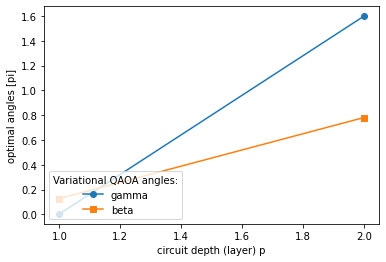

In [18]:
gamma = result_angle[:p]
beta = result_angle[p:]
pa = np.arange(1, p + 1)

fig = plt.figure(2)
plt.plot(pa, gamma / np.pi, '-o', label='gamma')
plt.plot(pa, beta / np.pi, '-s', label='beta')
plt.xlabel('circuit depth (layer) p')
plt.ylabel('optimal angles [pi]')
plt.legend(title='Variational QAOA angles:', loc='lower left')
plt.show()

Minimal energy found from QAOA job: -10


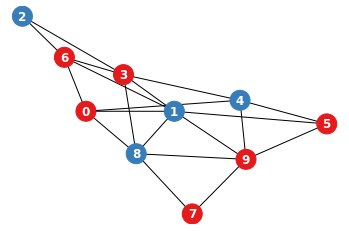

In [19]:
# visualize solution of managed job
colorlist = tracker['optimal_bitstring']
colorlist[colorlist == -1] = 0

# plot_colored_graph(J, N, colorlist, pos)
plot_colored_graph_simple(G, colorlist, pos)
print('Minimal energy found from QAOA job:', tracker['optimal_energy'])

Classical solution: {'s0': 1, 's1': -1, 's2': 1, 's3': 1, 's4': -1, 's5': 1, 's6': -1, 's7': -1, 's8': -1, 's9': 1}
Minimal energy found classically: -10


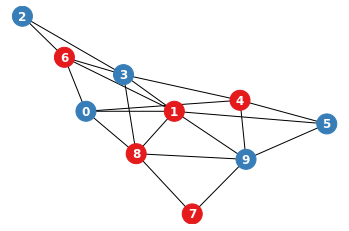

In [20]:
# validate quantum results with classical algorithm
solution, decoded_solution, energy_min, colors_classical = solve_classical_ising(J, J.shape[0], pos)
# plot classical solution
plot_colored_graph_simple(G, colors_classical, pos)

<span style="color:red">__TODO__:</span>: Add discussion. 
In this small toy problem there are many degenerate classical solutions with the same optimal quality. 